In [1247]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt

In [1248]:
# show fully evaluated experiments => experiments with step_results_eval.csv
# f"../results/{dataset}/{model}/{optim}/*/*/*/step_results_eval.csv"
# => print(f"{Model} evaluated on {Dataset} with {Optim} on {Seeds}")

exps = glob("../results/**/step_results_eval.csv", recursive=True)
models = set()
datasets = set()
opts = set()
seeds = set()

ran_exps = {}  # {(dataset, model, optim): seeds}
for exp in exps:
    dataset, model, optim, seed, _, _, _ = (
        exp.replace("sst-5", "sst5").replace("\\", "/").split("/")[-7:]
    )
    models.add(model)
    datasets.add(dataset)
    opts.add(optim)
    seeds.add(seed)

    ran_exps[(dataset, model, optim)] = seeds

# print ran exps if all seeds are present, than print "CAPO evaluated on gsm8k with qwen, llama, mistral"
for optim in opts:
    for dataset in datasets:
        # find models that have all seeds
        evaluated_models = []
        for model in models:
            if (dataset, model, optim) in ran_exps:
                evaluated_models.append(model)
        if len(evaluated_models) != 0:
            print(f"{optim} evaluated on {dataset} with {', '.join(evaluated_models)}")

EvoPromptGA evaluated on sst5 with llama, qwen
EvoPromptGA evaluated on subj with mistral, llama, qwen
EvoPromptGA evaluated on gsm8k with mistral, llama, qwen
EvoPromptGA evaluated on copa with mistral, llama, qwen
EvoPromptGA evaluated on agnews with llama, qwen
CAPO evaluated on sst5 with mistral, llama, qwen
CAPO evaluated on subj with mistral, llama, qwen
CAPO evaluated on gsm8k with llama, qwen
CAPO evaluated on copa with llama, qwen
CAPO evaluated on agnews with mistral, llama, qwen
OPRO evaluated on sst5 with llama, qwen
OPRO evaluated on subj with qwen
OPRO evaluated on agnews with mistral, llama, qwen
PromptWizard evaluated on subj with mistral, llama, qwen
PromptWizard evaluated on gsm8k with llama
PromptWizard evaluated on agnews with qwen


In [1249]:
# missing eval
missing_exps = []
for dataset in datasets:
    for model in models:
        for optim in opts:
            if (dataset, model, optim) not in ran_exps:
                missing_exps.append((dataset, model, optim))

for dataset in datasets:
    for optim in opts:
        # find models that have all seeds
        evaluated_models = []
        for model in models:
            if (dataset, model, optim) not in ran_exps:
                evaluated_models.append(model)
        if len(evaluated_models) != 0:
            print(f"{optim} not evaluated on {dataset} with {', '.join(evaluated_models)}")

EvoPromptGA not evaluated on sst5 with mistral
OPRO not evaluated on sst5 with mistral
PromptWizard not evaluated on sst5 with mistral, llama, qwen
OPRO not evaluated on subj with mistral, llama
CAPO not evaluated on gsm8k with mistral
OPRO not evaluated on gsm8k with mistral, llama, qwen
PromptWizard not evaluated on gsm8k with mistral, qwen
CAPO not evaluated on copa with mistral
OPRO not evaluated on copa with mistral, llama, qwen
PromptWizard not evaluated on copa with mistral, llama, qwen
EvoPromptGA not evaluated on agnews with mistral
PromptWizard not evaluated on agnews with mistral, llama


In [1289]:
def get_data(dataset, model, optim):
    paths = [
        f"../results/{dataset}/{model}/{optim}/*/*/*/step_results_eval.csv",
        f"../ablation_results/{dataset}/{model}/{optim}/*/*/*/step_results_eval.csv",
        f"../hp_results/{dataset}/{model}/{optim}/*/*/*/step_results_eval.csv",
    ]
    files = []
    for path in paths:
        files.extend(glob(path))
    # filter out any with "hyper" in name
    seeds = [int(f.replace("sst-5", "sst5").split("\\")[-4].split("seed")[-1]) for f in files]
    df = pd.concat([pd.read_csv(p).assign(seed=seed) for seed, p in zip(seeds, files)], axis=0)
    if "score" not in df.columns:
        df["score"] = 0  # -> is promptwizard with only one prompt
    # calc tokens
    df["token"] = (
        df["input_tokens_meta_llm"] + df["input_tokens_downstream_llm"]
    )  # + df["output_tokens_meta_llm"] + df["output_tokens_downstream_llm"]

    tokens = df.groupby(["seed", "step"]).first()["token"]
    cum_token_map = tokens.groupby("seed").cumsum().to_dict()
    df["cum_token"] = df.apply(lambda x: cum_token_map[(x.seed, x.step)], axis=1)

    # calc prompt lens
    df["instr_len"] = df["prompt"].str.split("Input:").apply(lambda x: x[0]).str.split().apply(len)
    df["prompt_len"] = df["prompt"].str.split().apply(len)

    return df


def aggregate_population_scores(df, how="mean"):
    if how == "mean":
        df = df.groupby(["step", "seed"], as_index=False).mean(numeric_only=True)
    elif how == "median":
        df = df.groupby(["step", "seed"], as_index=False).median(numeric_only=True)
    elif how == "best_test":
        df = df.sort_values("test_score", ascending=False)
        df = df.groupby(["step", "seed"], as_index=False).first()

    elif how == "best_train":
        df = df.sort_values("score", ascending=False)
        df = df.groupby(["step", "seed"], as_index=False).first()
    else:
        raise ValueError(f"Unknown aggregation method {how}")

    return df


def plot_population_scores(
    dataset, model, optim, agg="mean", plot_seeds=False, score_col="test_score", x_col="step"
):
    fig, ax = plt.subplots()
    df = get_data(dataset, model, optim)
    df = aggregate_population_scores(df, agg)

    if plot_seeds:
        for seed in df.seed.unique():
            df_seed = df[df.seed == seed]
            ax.plot(df_seed[x_col], df_seed[score_col], linestyle="--")

    df_max = df.groupby("step", as_index=False).max(numeric_only=True)
    df_avg = df.groupby("step", as_index=False).mean(numeric_only=True)
    df_std = df.groupby("step", as_index=False).std(numeric_only=True)
    df_avg["cum_token"] = df_max["cum_token"]
    df_std["cum_token"] = df_max["cum_token"]
    min_steps = df.groupby("seed")["step"].max().min()
    df_avg = df_avg[df_avg.step <= min_steps]
    df_std = df_std[df_std.step <= min_steps]

    ax.plot(df_avg[x_col], df_avg[score_col], label="avg", color="black")
    ax.fill_between(
        df_avg[x_col],
        df_avg.test_score - df_std.test_score,
        df_avg.test_score + df_std.test_score,
        alpha=0.3,
    )

    ax.set_xlabel(x_col)
    ax.set_ylabel(score_col)
    ax.set_title(f"{dataset} - {model} - {optim} - {agg}")
    ax.legend()

    return fig


def plot_population_members(dataset, model, optim, x_col="step"):
    fig, ax = plt.subplots()
    df = get_data(dataset, model, optim)

    for seed in df.seed.unique():
        df_seed = df[df.seed == seed]
        ax.scatter(df_seed[x_col], df_seed["test_score"], label=f"seed {seed}", alpha=0.3, s=3)

    ax.set_xlabel("Step")
    ax.set_ylabel("score")
    ax.set_title(f"{dataset} - {model} - {optim}")
    ax.legend()

    return fig


def plot_population_scores_comparison(
    dataset,
    model,
    optims,
    agg="mean",
    plot_seeds=False,
    plot_std=True,
    score_col="test_score",
    x_col="step",
):
    fig, ax = plt.subplots(figsize=(10, 6))

    colors = ["blue", "red", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

    for i, optim in enumerate(optims):
        try:
            df = get_data(dataset, model, optim)
            df = aggregate_population_scores(df, agg)
        except Exception as e:
            print(e)
            continue
        df_avg = df.groupby("step", as_index=False).mean(numeric_only=True)
        df_std = df.groupby("step", as_index=False).std(numeric_only=True)
        df_std["cum_token"] = df_avg["cum_token"]

        min_steps = df.groupby("seed")["step"].max().min()
        df_avg = df_avg[df_avg.step <= min_steps]
        df_std = df_std[df_std.step <= min_steps]

        ax.plot(df_avg[x_col], df_avg[score_col], label=f"{optim}", color=colors[i], linewidth=2)

        # Plot individual seeds if requested
        if plot_seeds:
            for seed in df.seed.unique():
                df_seed = df[df.seed == seed]
                ax.plot(
                    df_seed[x_col], df_seed[score_col], linestyle="--", alpha=0.3, color=colors[i]
                )  # , label=f"{optim} seed {seed}")
        if plot_std:
            # Calculate and plot mean and std

            ax.fill_between(
                df_avg[x_col],
                df_avg[score_col] - df_std[score_col],
                df_avg[score_col] + df_std[score_col],
                alpha=0.2,
                color=colors[i],
            )

    ax.set_xlabel(x_col)
    ax.set_ylabel(score_col)
    ax.set_title(f"{dataset} - {model} - Comparison - {agg}")
    ax.legend()

    return fig


def generate_comparison_table(
    datasets=["sst-5", "agnews", "copa", "gsm8k", "subj"],
    optimizers=["CAPO", "EvoPromptGA"],
    model="llama",
    cutoff_tokens=5_000_000,
    agg="best_train",
):
    results = {"optimizer": [], "dataset": [], "mean": [], "std": []}

    for optimizer in optimizers:
        for dataset in datasets:
            try:
                df = get_data(dataset, model, optimizer)
                df = aggregate_population_scores(df, agg)
            except Exception as e:
                print(e)
                continue
            steps_data = []
            for seed in df.seed.unique():
                df_seed = df[df.seed == seed]

                last_step = df_seed.loc[df_seed["cum_token"] < cutoff_tokens, "step"].max()

                step_df = df_seed[df_seed["step"] == last_step]
                steps_data.append(step_df)

            combined_df = pd.concat(steps_data)
            results["mean"].append(combined_df["test_score"].mean())
            results["std"].append(combined_df["test_score"].std())
            results["optimizer"].append(optimizer)
            results["dataset"].append(dataset)

    df = pd.DataFrame(results)
    df = df.set_index("optimizer")
    df = df.pivot(columns="dataset")

    # styling
    df["avg"] = df["mean"].mean(axis=1).mul(100).round(2).astype(str)
    df["mean"] = df["mean"].mul(100).round(1)
    df["std"] = df["std"].mul(100).round(1)

    df["mean"] = (
        df["mean"].astype(str).apply(lambda x: x[:5])
        + "±"
        + df["std"].astype(str).apply(lambda x: x[:5])
    )
    df = df.drop(columns=["std"])
    df.columns = [col[1] if col[0] == "mean" else col[0] for col in df.columns]
    df.index.name = None
    try:
        df = df.style.highlight_max(axis=0, props="font-weight: bold;")
    except Exception as e:
        print(e)
        pass
    return df


def compare_multi_obj(
    dataset,
    optimizers=["CAPO", "EvoPromptGA"],
    model="llama",
    cutoff_tokens=5_000_000,
):
    # compare model_len as well as test_score for each member of the final population
    results = {"optimizer": [], "test_score": [], "prompt_len": []}

    for optimizer in optimizers:
        df = get_data(dataset, model, optimizer)

        step_dfs = []
        for seed in df.seed.unique():
            df_seed = df[df.seed == seed]
            last_step = df_seed.loc[df_seed["cum_token"] < cutoff_tokens, "step"].max()
            step_df = df_seed[df_seed["step"] == last_step]
            step_dfs.append(step_df)

        combined_df = pd.concat(step_dfs)
        results["test_score"] += combined_df["test_score"].tolist()
        results["prompt_len"] += (
            combined_df["prompt"].str.split("Input:").apply(lambda x: x[0]).apply(len).tolist()
        )
        results["optimizer"] += [optimizer] * len(combined_df)

    df = pd.DataFrame(results)

    fig, ax = plt.subplots()
    for optimizer in optimizers:
        df_opt = df[df.optimizer == optimizer]
        ax.scatter(df_opt["prompt_len"], df_opt["test_score"], label=optimizer, alpha=0.5)

    ax.set_xlabel("Instruction Length")
    ax.set_ylabel("Test Score")
    ax.set_title(f"{dataset} - {model} - Comparison")
    ax.legend()

    return fig


def plot_prompt_lens(
    dataset,
    optimizer,
    model="llama",
    y_col="prompt_len",
):
    # box plot for every step
    df = get_data(dataset, model, optimizer)
    steps = df.step.unique()
    fig, ax = plt.subplots()
    for step in steps:
        df_step = df[df.step == step]
        ax.boxplot(df_step[y_col], positions=[step])  # , showfliers=False)

    ax.set_xlabel("Step")
    ax.set_ylabel(y_col)
    ax.set_title(f"{dataset} - {model} - {optimizer} - {y_col}")

    return fig

# Optimizer Comparison

## Llama

In [1291]:
generate_comparison_table(
    model="llama",
    agg="best_train",
    optimizers=["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
    cutoff_tokens=5_000_000,
)

No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate


,agnews,copa,gsm8k,sst-5,subj,avg
CAPO,89.1±0.6,98.3±0.6,73.7±4.6,62.3±0.5,91.6±2.6,83.0
EvoPromptGA,88.7±0.5,97.7±1.5,51.3±1.2,60.5±1.7,75.8±0.2,74.8
Opro,88.2±0.6,nan±nan,nan±nan,60.9±1.3,nan±nan,74.53
PromptWizard,nan±nan,nan±nan,34.1±22.8,nan±nan,51.9±0.3,43.02


No objects to concatenate


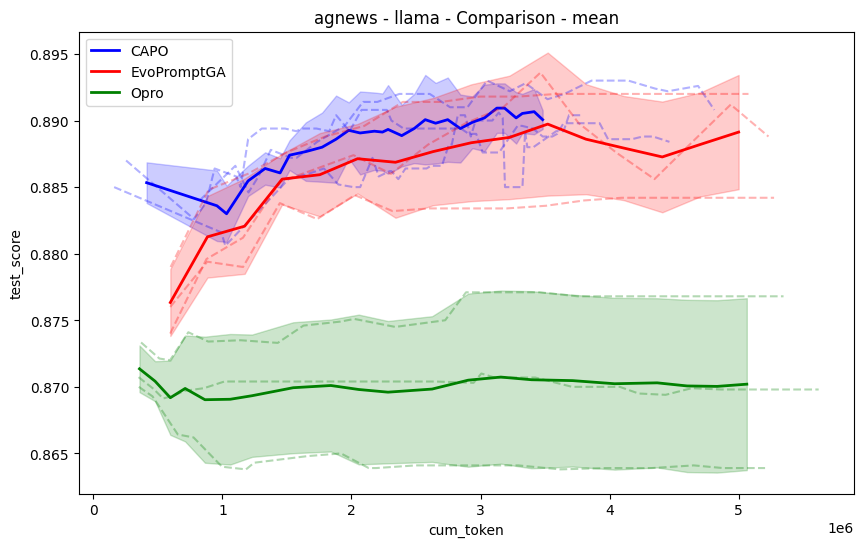

In [1292]:
plot_population_scores_comparison(
    "agnews",
    "llama",
    ["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
    "mean",
    plot_seeds=True,
    plot_std=True,
    x_col="cum_token",
);

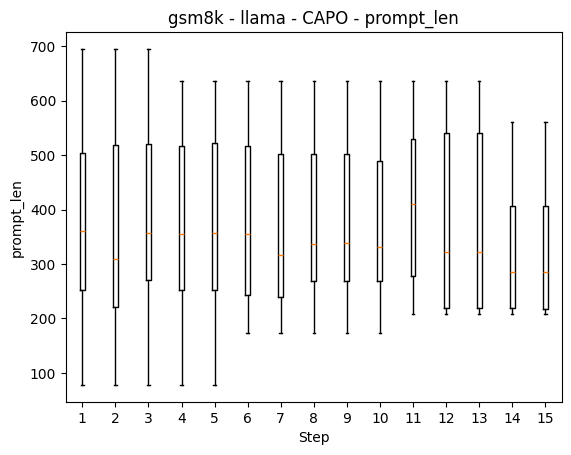

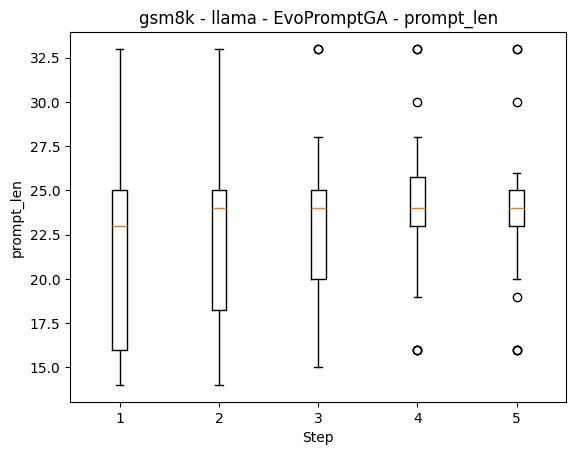

In [1253]:
plot_prompt_lens("gsm8k", "CAPO")
plot_prompt_lens("gsm8k", "EvoPromptGA");

## Mistral

In [1293]:
generate_comparison_table(
    model="mistral",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
)

No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate


,agnews,copa,gsm8k,sst-5,subj,avg
CAPO,84.1±2.6,nan±nan,nan±nan,60.2±0.4,81.7±2.0,75.31
EvoPromptGA,nan±nan,96.1±0.4,43.9±4.7,nan±nan,74.9±2.5,71.67
Opro,84.2±0.2,nan±nan,nan±nan,nan±nan,nan±nan,84.2
PromptWizard,nan±nan,nan±nan,nan±nan,nan±nan,55.4±0.3,55.4


No objects to concatenate


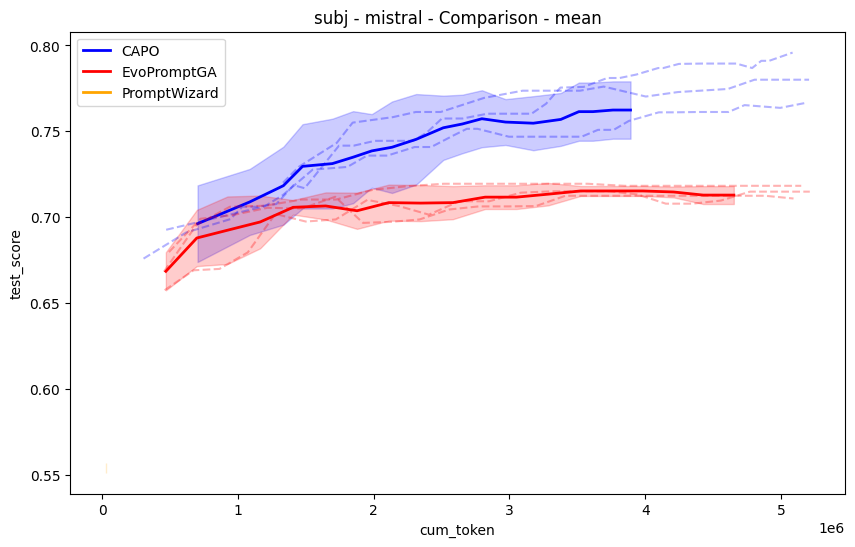

In [1294]:
plot_population_scores_comparison(
    "subj",
    "mistral",
    ["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
    "mean",
    plot_seeds=True,
    plot_std=True,
    x_col="cum_token",
);

## QWEN

In [1295]:
generate_comparison_table(
    model="qwen",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
)

No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate
No objects to concatenate


,agnews,copa,gsm8k,sst-5,subj,avg
CAPO,87.3±0.9,98.5±0.2,60.2±5.9,59.1±0.6,91.0±0.8,79.2
EvoPromptGA,81.7±2.1,97.9±0.8,61.3±10.3,58.6±2.1,75.9±4.4,75.07
Opro,80.0±0.0,nan±nan,nan±nan,56.7±0.4,69.0±nan,68.58
PromptWizard,82.4±nan,nan±nan,nan±nan,nan±nan,64.9±6.1,73.67


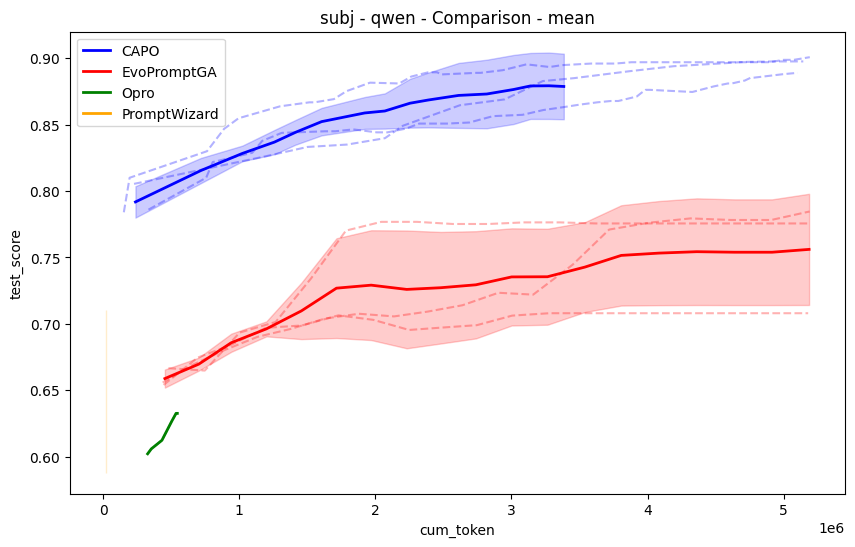

In [1296]:
plot_population_scores_comparison(
    "subj",
    "qwen",
    ["CAPO", "EvoPromptGA", "Opro", "PromptWizard"],
    "mean",
    plot_seeds=True,
    plot_std=True,
    x_col="cum_token",
);

# Ablation Study

In [1297]:
ablation_runs = [
    "CAPO",
    "EvoPromptGA",
    "EvoPromptGA_TA",
    "CAPO_zero_shot",
    "CAPO_no_lp",
    "CAPO_no_racing",
]

No objects to concatenate


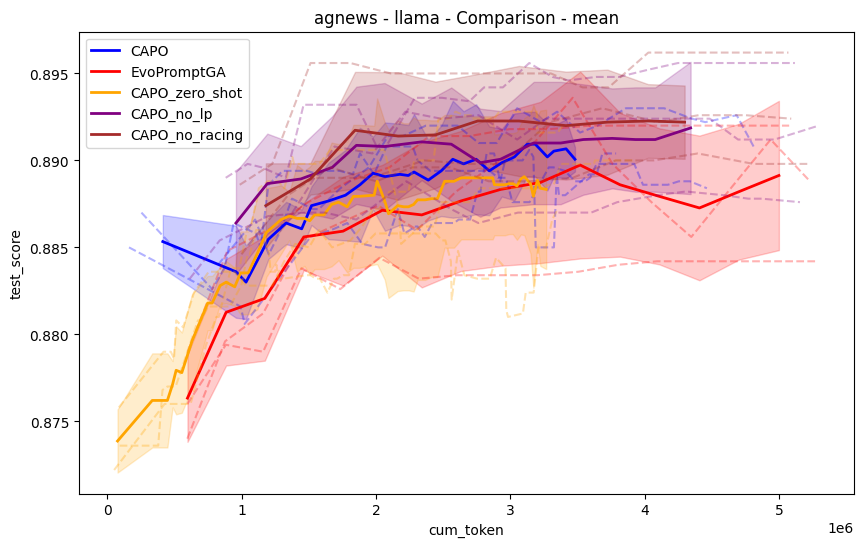

In [1298]:
plot_population_scores_comparison(
    "agnews", "llama", ablation_runs, "mean", plot_seeds=1, plot_std=1, x_col="cum_token"
);

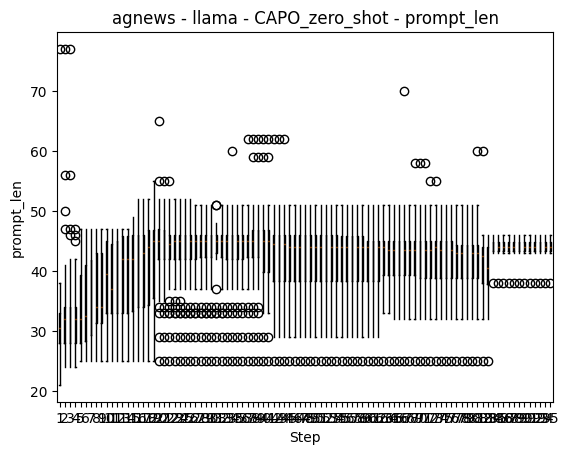

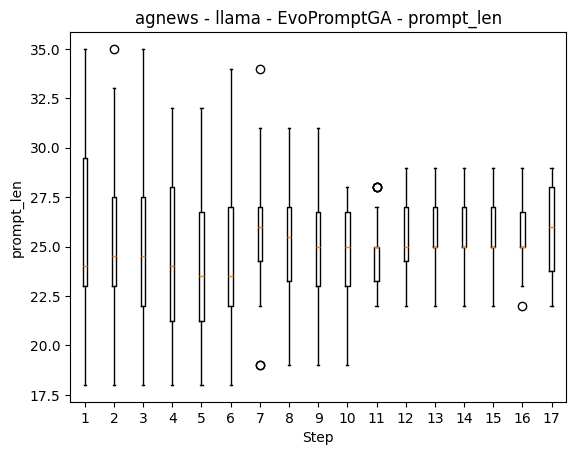

In [1299]:
plot_prompt_lens("agnews", "CAPO_zero_shot")
plot_prompt_lens("agnews", "EvoPromptGA");

No objects to concatenate


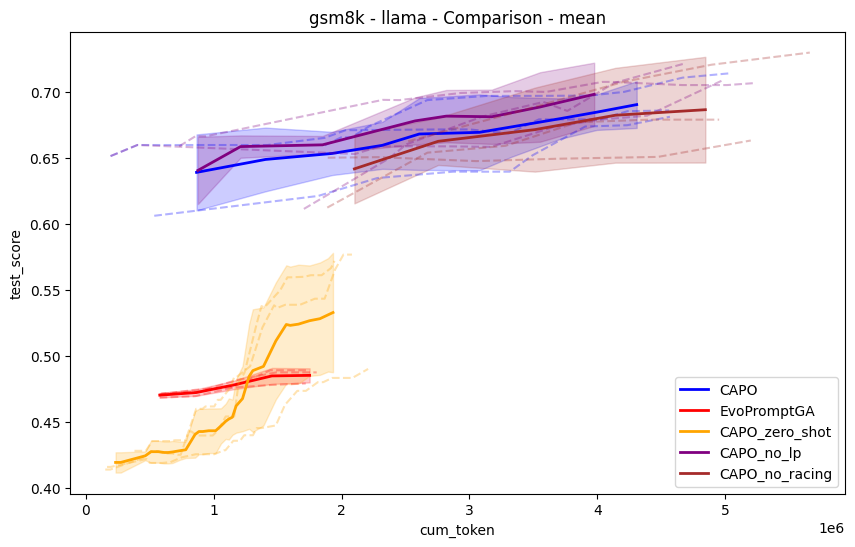

In [1300]:
plot_population_scores_comparison(
    "gsm8k", "llama", ablation_runs, "mean", plot_seeds=1, plot_std=1, x_col="cum_token"
);

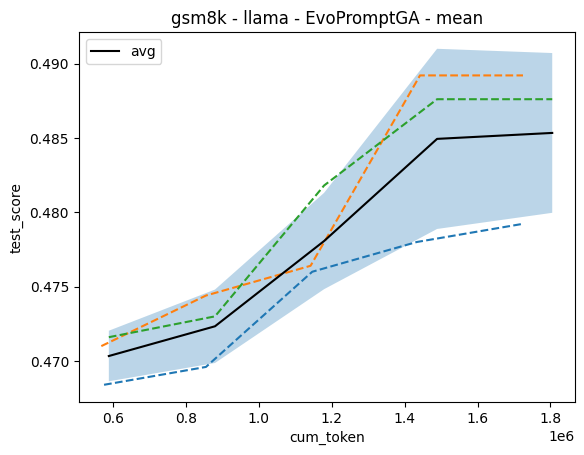

In [1262]:
plot_population_scores("gsm8k", "llama", "EvoPromptGA", plot_seeds=1, x_col="cum_token");

In [1301]:
generate_comparison_table(
    model="llama",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=ablation_runs,
    datasets=["agnews", "gsm8k"],
)

No objects to concatenate
No objects to concatenate


,agnews,gsm8k,avg
CAPO,89.1±0.6,73.7±4.6,81.4
CAPO_no_lp,89.2±0.4,74.9±1.3,82.07
CAPO_no_racing,89.5±0.5,75.0±3.8,82.27
CAPO_zero_shot,89.0±0.2,62.4±7.5,75.7
EvoPromptGA,88.7±0.5,51.3±1.2,69.97


# HP search 

### gamma

In [1302]:
hp_runs = [
    "CAPO",
    "CAPO_gamma_0.01",
    "CAPO_gamma_0.05",
    "CAPO_gamma_0.1",
]

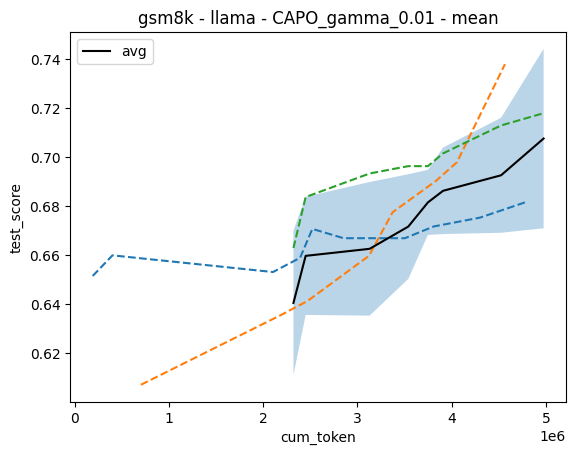

In [1303]:
plot_population_scores(
    "gsm8k",
    "llama",
    "CAPO_gamma_0.01",
    "mean",
    plot_seeds=True,
    score_col="test_score",
    x_col="cum_token",
);

No objects to concatenate
No objects to concatenate


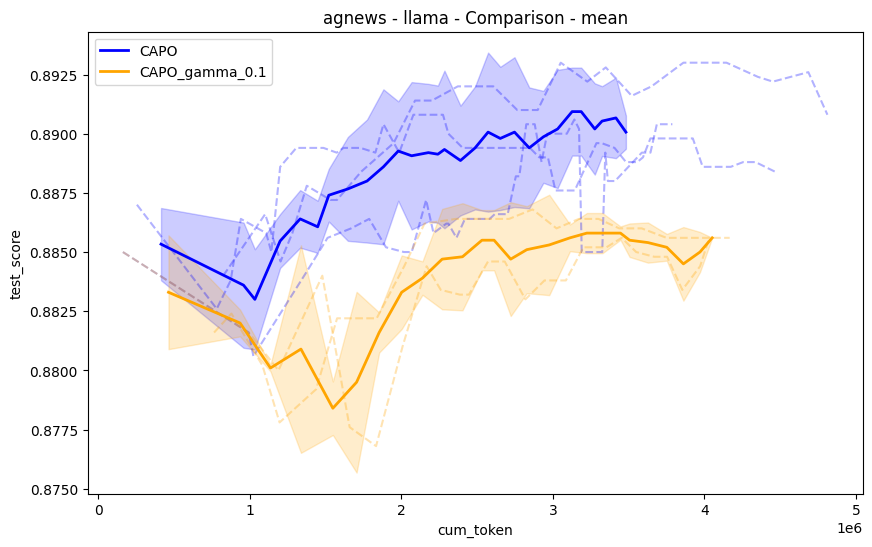

In [1304]:
plot_population_scores_comparison(
    "agnews", "llama", hp_runs, "mean", plot_seeds=True, plot_std=True, x_col="cum_token"
);

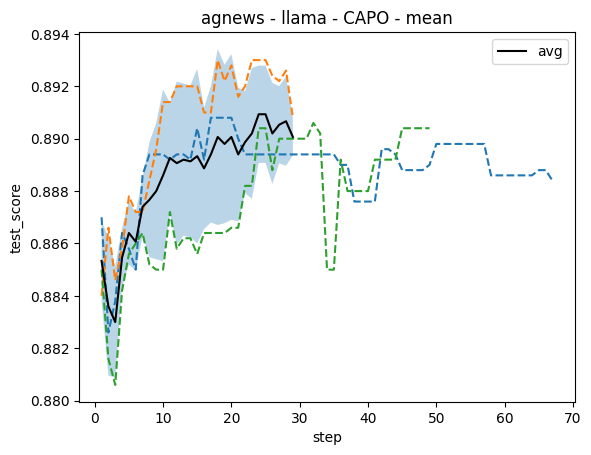

In [1267]:
plot_population_scores(
    "agnews", "llama", "CAPO", "mean", plot_seeds=1, score_col="test_score", x_col="step"
);

In [1268]:
generate_comparison_table(
    model="llama",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=hp_runs,
    datasets=["agnews", "gsm8k"],
)

No objects to concatenate
No objects to concatenate


,agnews,gsm8k,avg
CAPO,89.1±0.6,73.7±4.6,81.4
CAPO_gamma_0.01,nan±nan,75.3±3.8,75.27
CAPO_gamma_0.05,nan±nan,73.7±4.6,73.73
CAPO_gamma_0.1,89.0±0.3,74.8±3.9,81.9


### N_crossovers

In [1269]:
hp_runs = [
    "CAPO",
    "CAPO_ncrossovers_4",
    "CAPO_ncrossovers_7",
    "CAPO_ncrossovers_10",
]

No objects to concatenate


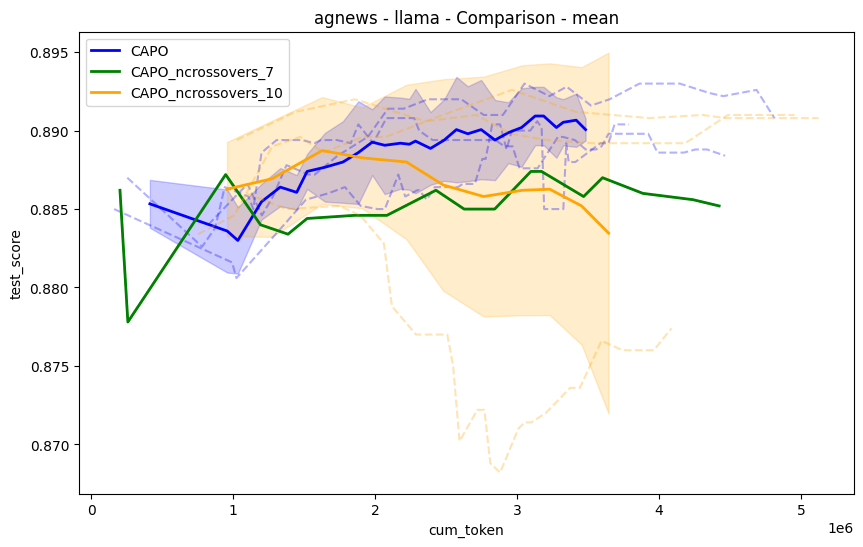

In [1270]:
plot_population_scores_comparison(
    "agnews", "llama", hp_runs, "mean", plot_seeds=True, plot_std=True, x_col="cum_token"
);

In [1271]:
generate_comparison_table(
    model="llama",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=hp_runs,
    datasets=["agnews", "gsm8k"],
)

No objects to concatenate


,agnews,gsm8k,avg
CAPO,89.1±0.6,73.7±4.6,81.4
CAPO_ncrossovers_10,89.5±0.2,79.0±nan,84.27
CAPO_ncrossovers_4,nan±nan,73.7±4.6,73.73
CAPO_ncrossovers_7,89.2±nan,74.1±0.9,81.67


### Pop size

In [1272]:
hp_runs = ["CAPO", "CAPO_pop_6", "CAPO_pop_8", "CAPO_pop_10", "CAPO_pop_12"]

No objects to concatenate


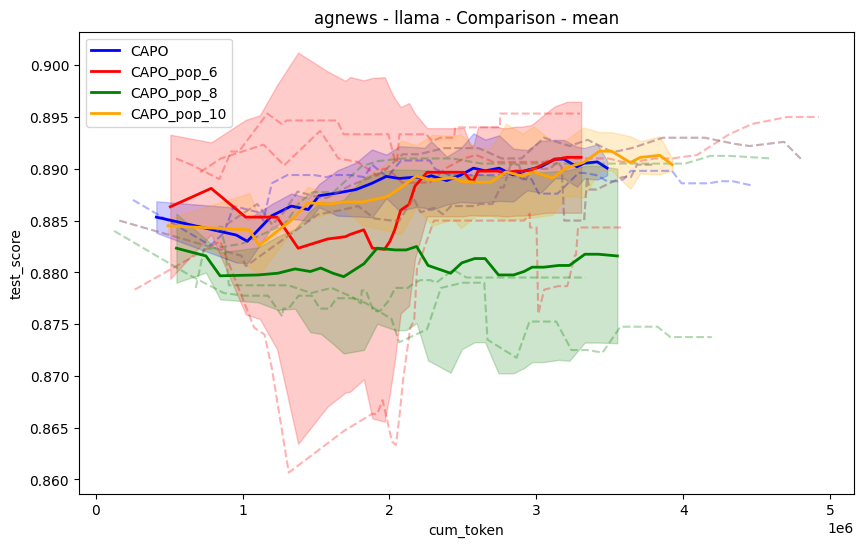

In [1273]:
plot_population_scores_comparison(
    "agnews", "llama", hp_runs, "mean", plot_seeds=True, plot_std=True, x_col="cum_token"
);

In [1274]:
generate_comparison_table(
    model="llama",
    agg="best_train",
    cutoff_tokens=5_000_000,
    optimizers=hp_runs,
    datasets=["agnews", "gsm8k"],
)

No objects to concatenate


,agnews,gsm8k,avg
CAPO,89.1±0.6,73.7±4.6,81.4
CAPO_pop_10,88.7±0.1,73.7±4.6,81.22
CAPO_pop_12,nan±nan,76.9±1.6,76.87
CAPO_pop_6,89.0±0.6,77.7±3.7,83.33
CAPO_pop_8,88.3±0.3,77.7±4.6,83.0


# unverified plots! 👇🏻

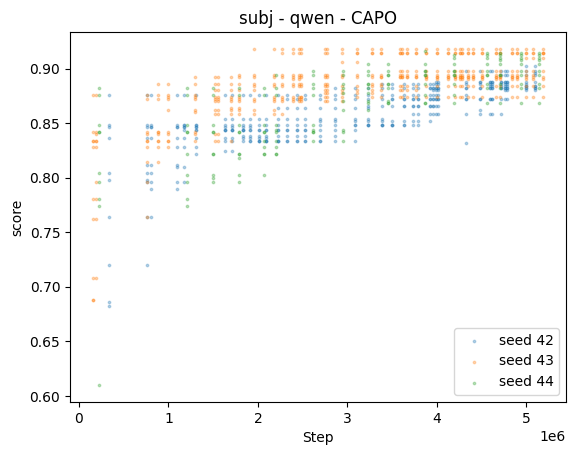

In [1275]:
plot_population_members(DATASET, MODEL, OPTIM, x_col="cum_token");

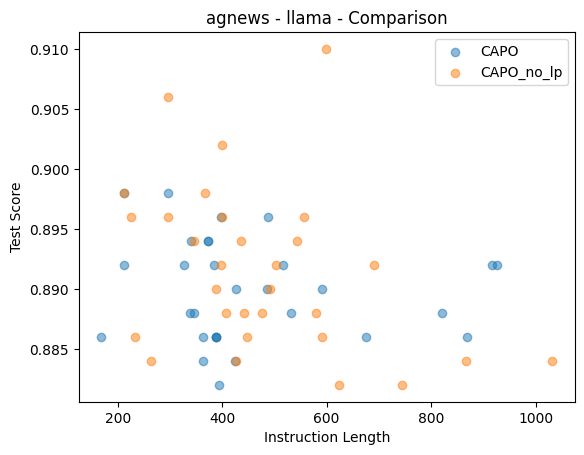

In [1276]:
compare_multi_obj("agnews", model="llama", optimizers=["CAPO", "CAPO_no_lp"]);

In [1277]:
# def analyze_convergence_rate(
#     dataset, model, optims, agg="mean", score_col="test_score", convergence_threshold=0.9
# ):
#     """
#     Analyze how quickly each algorithm converges to its maximum performance.

#     Parameters:
#     -----------
#     convergence_threshold : float
#         The fraction of maximum performance used to define convergence
#         (e.g., 0.9 means 90% of the maximum score)
#     """
#     fig, ax = plt.subplots(figsize=(10, 6))

#     colors = ["blue", "red"]
#     results = []

#     for i, optim in enumerate(optims):
#         df = get_data(dataset, model, optim)
#         df = aggregate_population_scores(df, agg)

#         df_avg = df.groupby("step", as_index=False).max(numeric_only=True)

#         # Get the maximum score achieved by this optimizer
#         max_score = df_avg[score_col].max()
#         threshold_score = max_score * convergence_threshold

#         # Find when the algorithm first crosses the threshold
#         try:
#             convergence_point = df_avg[df_avg[score_col] >= threshold_score].iloc[0]
#             tokens_to_converge = convergence_point["cum_token"]
#             steps_to_converge = convergence_point["step"]

#             # Plot vertical line at convergence point
#             ax.axvline(x=tokens_to_converge, color=colors[i], linestyle="--", alpha=0.5)

#             # Store result
#             results.append(
#                 {
#                     "optimizer": optim,
#                     "dataset": dataset,
#                     "model": model,
#                     "tokens_to_converge": tokens_to_converge,
#                     "steps_to_converge": steps_to_converge,
#                     "max_score": max_score,
#                 }
#             )
#         except IndexError:
#             # Optimizer never reaches the threshold
#             print(f"{optim} never reaches {convergence_threshold*100}% of its maximum performance")
#             results.append(
#                 {
#                     "optimizer": optim,
#                     "dataset": dataset,
#                     "model": model,
#                     "tokens_to_converge": float("inf"),
#                     "steps_to_converge": float("inf"),
#                     "max_score": max_score,
#                 }
#             )

#         # Plot performance curve
#         ax.plot(
#             df_avg["cum_token"],
#             df_avg[score_col],
#             label=f"{optim} (max: {max_score:.3f})",
#             color=colors[i],
#             linewidth=2,
#         )

#     ax.set_xlabel("Cumulative Tokens")
#     ax.set_ylabel(score_col)
#     ax.set_title(
#         f"{dataset} - {model} - Convergence Analysis ({convergence_threshold*100}% threshold)"
#     )
#     ax.legend()

#     # Create a DataFrame with the convergence results
#     results_df = pd.DataFrame(results)

#     return fig, results_df


# def plot_convergence_comparison(
#     datasets=["sst-5", "agnews", "rte", "gsm8k", "subj"],
#     optimizers=["CAPO", "EvoPromptGA"],
#     model="llama",
# ):
#     """
#     Create a bar chart comparing tokens to convergence across datasets.
#     """
#     all_results = []

#     for dataset in datasets:
#         _, results_df = analyze_convergence_rate(dataset, model, optimizers)
#         all_results.append(results_df)

#     combined_results = pd.concat(all_results)

#     # Create grouped bar chart
#     fig, ax = plt.subplots(figsize=(12, 6))

#     # Get unique datasets and optimizers
#     unique_datasets = combined_results["dataset"].unique()
#     unique_optims = combined_results["optimizer"].unique()

#     x = np.arange(len(unique_datasets))
#     width = 0.35

#     # Create bars for each optimizer
#     for i, optim in enumerate(unique_optims):
#         optim_data = combined_results[combined_results["optimizer"] == optim]

#         # Convert 'inf' to a large but finite number for plotting
#         tokens_data = [
#             optim_data[optim_data["dataset"] == dataset]["tokens_to_converge"].values[0]
#             if dataset in optim_data["dataset"].values
#             and optim_data[optim_data["dataset"] == dataset]["tokens_to_converge"].values[0]
#             != float("inf")
#             else np.nan
#             for dataset in unique_datasets
#         ]

#         # Plot bars
#         ax.bar(x + (i - 0.5) * width, tokens_data, width, label=optim)

#     # Customize the plot
#     ax.set_xlabel("Dataset")
#     ax.set_ylabel("Tokens to Convergence")
#     ax.set_title(f"Tokens Required to Reach 90% of Maximum Performance - {model}")
#     ax.set_xticks(x)
#     ax.set_xticklabels(unique_datasets)
#     ax.legend()

#     return fig


# import numpy as np

# # Example usage
# _, results_df = analyze_convergence_rate(
#     "gsm8k", "llama", ["CAPO", "EvoPromptGA"], convergence_threshold=0.99
# )
# plot_convergence_comparison();

In [1278]:
# def plot_compute_efficiency(
#     dataset, model, optims, cost_per_1k_tokens=0.005, score_col="test_score"
# ):
#     """
#     Analyze the cost-effectiveness of each algorithm.

#     This assumes a simple cost model based on token usage.
#     Adapt the cost_per_1k_tokens parameter based on your model costs.
#     """
#     fig, ax = plt.subplots(figsize=(10, 6))

#     colors = ["blue", "red"]

#     for i, optim in enumerate(optims):
#         df = get_data(dataset, model, optim)
#         df = aggregate_population_scores(df, "mean")

#         df_avg = df.groupby("step", as_index=False).mean(numeric_only=True)

#         # Calculate cost
#         df_avg["cost"] = df_avg["cum_token"] * cost_per_1k_tokens / 1000

#         # Calculate cost effectiveness as score per dollar
#         df_avg["cost_effectiveness"] = df_avg[score_col] / df_avg["cost"]

#         # Plot cost effectiveness
#         ax.plot(
#             df_avg["cum_token"],
#             df_avg["cost_effectiveness"],
#             label=f"{optim}",
#             color=colors[i],
#             linewidth=2,
#         )

#     ax.set_xlabel("Cumulative Tokens")
#     ax.set_ylabel("Score per Dollar")
#     ax.set_title(f"{dataset} - {model} - Cost Effectiveness")
#     ax.legend()

#     return fig


# def plot_cost_performance_tradeoff(
#     datasets=["sst-5", "agnews", "rte", "gsm8k", "subj"],
#     optimizers=["CAPO", "EvoPromptGA"],
#     model="llama",
#     cutoff_tokens=5_000_000,
#     cost_per_1k_tokens=0.005,
#     agg="mean",
# ):
#     """
#     Create a scatter plot showing the cost-performance tradeoff across datasets.
#     """
#     fig, ax = plt.subplots(figsize=(10, 8))

#     # Define markers for datasets
#     markers = ["o", "s", "^", "D", "p"]  # circle, square, triangle, diamond, pentagon

#     # Store results for annotation
#     results = []

#     # Loop through optimizers and datasets
#     for i, optim in enumerate(optimizers):
#         costs = []
#         scores = []
#         dataset_labels = []

#         for j, dataset in enumerate(datasets):
#             try:
#                 df = get_data(dataset, model, optim)
#                 df = aggregate_population_scores(df, agg)

#                 # Get values at token cutoff
#                 max_steps = []
#                 for seed in df.seed.unique():
#                     df_seed = df[df.seed == seed]
#                     last_step = df_seed.loc[df_seed["cum_token"] < cutoff_tokens, "step"].max()
#                     if pd.isna(last_step):
#                         continue
#                     max_steps.append(df_seed[df_seed["step"] == last_step])

#                 if max_steps:
#                     final_df = pd.concat(max_steps)
#                     avg_score = final_df["test_score"].mean() * 100  # Convert to percentage
#                     avg_tokens = final_df["cum_token"].mean()
#                     cost = avg_tokens * cost_per_1k_tokens / 1000  # Cost in dollars

#                     costs.append(cost)
#                     scores.append(avg_score)
#                     dataset_labels.append(dataset)

#                     # Store result
#                     results.append(
#                         {"dataset": dataset, "optimizer": optim, "cost": cost, "score": avg_score}
#                     )
#             except Exception as e:
#                 print(f"Error processing {dataset} - {optim}: {e}")

#         # Plot scatter points
#         for j, (cost, score, dataset) in enumerate(zip(costs, scores, dataset_labels)):
#             ax.scatter(
#                 cost,
#                 score,
#                 marker=markers[j % len(markers)],
#                 s=100,
#                 color=f"C{i}",
#                 label=f"{optim} - {dataset}",
#             )

#     # Add labels
#     ax.set_xlabel("Estimated Cost ($)")
#     ax.set_ylabel("Test Score (%)")
#     ax.set_title(f"Cost-Performance Tradeoff - {model}")

#     # Add legend outside the plot
#     ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

#     # Adjust layout to make room for the legend
#     plt.tight_layout(rect=[0, 0, 0.85, 1])

#     # Create results dataframe
#     results_df = pd.DataFrame(results)

#     return fig, results_df


# # Example usage
# plot_compute_efficiency("gsm8k", "llama", ["CAPO", "EvoPromptGA"])
# plot_cost_performance_tradeoff();

In [1279]:
# def fit_learning_curve(dataset, model, optims, score_col="test_score"):
#     """
#     Fit a learning curve model to estimate asymptotic performance.
#     Uses an exponential approach model: s(t) = a - b*exp(-c*t)
#     where:
#     - a is the asymptotic performance
#     - b is the scaling factor
#     - c is the learning rate
#     - t is the number of tokens
#     """
#     from scipy.optimize import curve_fit

#     fig, ax = plt.subplots(figsize=(10, 6))

#     colors = ["blue", "red"]
#     results = []

#     # Define learning curve function
#     def learning_curve(x, a, b, c):
#         return a - b * np.exp(-c * x)

#     for i, optim in enumerate(optims):
#         df = get_data(dataset, model, optim)
#         df = aggregate_population_scores(df, "mean")

#         df_avg = df.groupby("step", as_index=False).mean(numeric_only=True)

#         # Prepare data for fitting
#         x_data = df_avg["cum_token"].values
#         y_data = df_avg[score_col].values

#         try:
#             # Initial parameter guess
#             p0 = [max(y_data) * 1.1, max(y_data) - min(y_data), 1e-6]

#             # Fit curve
#             popt, pcov = curve_fit(learning_curve, x_data, y_data, p0=p0, maxfev=10000)

#             # Extract parameters
#             a, b, c = popt

#             # Calculate extrapolated performance
#             x_extrapolated = np.linspace(min(x_data), max(x_data) * 2, 100)
#             y_extrapolated = learning_curve(x_extrapolated, a, b, c)

#             # Plot actual data
#             ax.plot(x_data, y_data, "o", color=colors[i], alpha=0.5, label=f"{optim} (actual)")

#             # Plot fitted curve
#             ax.plot(
#                 x_extrapolated,
#                 y_extrapolated,
#                 "-",
#                 color=colors[i],
#                 label=f"{optim} (fitted, asymptote={a:.3f})",
#             )

#             # Store parameters
#             results.append(
#                 {
#                     "dataset": dataset,
#                     "model": model,
#                     "optimizer": optim,
#                     "asymptotic_performance": a,
#                     "scaling_factor": b,
#                     "learning_rate": c,
#                     "tokens_to_90pct": -np.log(0.1) / c if c > 0 else float("inf"),
#                     "tokens_to_95pct": -np.log(0.05) / c if c > 0 else float("inf"),
#                     "tokens_to_99pct": -np.log(0.01) / c if c > 0 else float("inf"),
#                 }
#             )

#         except Exception as e:
#             print(f"Error fitting curve for {optim}: {e}")

#     ax.set_xlabel("Cumulative Tokens")
#     ax.set_ylabel(score_col)
#     ax.set_title(f"{dataset} - {model} - Learning Curve Extrapolation")
#     ax.legend()

#     # Create results dataframe
#     results_df = pd.DataFrame(results)

#     return fig, results_df


# def plot_asymptotic_comparison(
#     datasets=["sst-5", "agnews", "rte", "gsm8k", "subj"],
#     optimizers=["CAPO", "EvoPromptGA"],
#     model="llama",
# ):
#     """
#     Create a bar chart comparing the estimated asymptotic performance across datasets.
#     """
#     fig, ax = plt.subplots(figsize=(12, 6))

#     # Store all results
#     all_results = []

#     for dataset in datasets:
#         try:
#             _, results_df = fit_learning_curve(dataset, model, optimizers)
#             all_results.append(results_df)
#         except Exception as e:
#             print(f"Error processing {dataset}: {e}")

#     # Combine results
#     if all_results:
#         combined_results = pd.concat(all_results)

#         # Set up grouped bar chart
#         unique_datasets = combined_results["dataset"].unique()
#         unique_optims = combined_results["optimizer"].unique()

#         x = np.arange(len(unique_datasets))
#         width = 0.35

#         # Create bars for each optimizer
#         for i, optim in enumerate(unique_optims):
#             optim_data = combined_results[combined_results["optimizer"] == optim]

#             asymptotic_data = [
#                 optim_data[optim_data["dataset"] == dataset]["asymptotic_performance"].values[0]
#                 * 100
#                 if dataset in optim_data["dataset"].values
#                 else np.nan
#                 for dataset in unique_datasets
#             ]

#             # Plot bars
#             ax.bar(x + (i - 0.5) * width, asymptotic_data, width, label=optim)

#         # Customize plot
#         ax.set_xlabel("Dataset")
#         ax.set_ylabel("Asymptotic Performance (%)")
#         ax.set_title(f"Predicted Maximum Performance - {model}")
#         ax.set_xticks(x)
#         ax.set_xticklabels(unique_datasets)
#         ax.legend()
#     else:
#         ax.text(0.5, 0.5, "No results available", ha="center", va="center", transform=ax.transAxes)

#     return fig


# # Example usage
# fit_learning_curve("gsm8k", "llama", ["CAPO", "EvoPromptGA"])
# plot_asymptotic_comparison()

In [1280]:
# def analyze_prompt_diversity(dataset, model, optimizers, seed=None, max_steps=None):
#     """
#     Analyze the diversity of prompts generated during optimization.

#     Diversity can be measured in multiple ways:
#     1. Lexical diversity (using metrics like TTR - Type-Token Ratio)
#     2. Semantic diversity (using embeddings and clustering)
#     3. Length distribution
#     4. Instruction pattern changes

#     Parameters:
#     -----------
#     dataset : str
#         The dataset name
#     model : str
#         The model name
#     optimizers : list
#         List of optimizer names to compare
#     seed : int, optional
#         If provided, analyze only this seed. Otherwise, analyze all seeds.
#     max_steps : int, optional
#         If provided, limit analysis to this many steps
#     """
#     import re
#     import numpy as np
#     from collections import Counter
#     import matplotlib.pyplot as plt
#     from sklearn.feature_extraction.text import TfidfVectorizer
#     from sklearn.metrics.pairwise import cosine_similarity

#     results = []

#     for optimizer in optimizers:
#         # Get data using the existing function
#         df = get_data(dataset, model, optimizer)

#         # Filter for specific seed if requested
#         if seed is not None:
#             df = df[df.seed == seed]

#         if df.empty:
#             print(f"No data found for {optimizer}")
#             continue

#         # Check if 'prompt' column exists
#         if "prompt" not in df.columns:
#             print(f"No 'prompt' column found for {optimizer}")
#             continue

#         # Group by seed and step to ensure we have one prompt per step
#         df_prompts = df.groupby(["seed", "step"]).first().reset_index()

#         # Limit steps if specified
#         if max_steps is not None and max_steps < len(df_prompts):
#             step_indices = list(range(0, len(df_prompts), len(df_prompts) // max_steps))
#             df_prompts = df_prompts.iloc[step_indices]

#         # Extract prompts, steps, and seeds
#         prompts = df_prompts["prompt"].tolist()
#         steps = df_prompts["step"].tolist()
#         seeds = df_prompts["seed"].tolist()

#         if not prompts:
#             print(f"No prompts found for {optimizer}")
#             continue

#         # Calculate lexical diversity (TTR) for each prompt
#         def calculate_ttr(text):
#             tokens = re.findall(r"\b\w+\b", text.lower())
#             if not tokens:
#                 return 0
#             return len(set(tokens)) / len(tokens)

#         ttrs = [calculate_ttr(p) for p in prompts]

#         # Calculate prompt lengths
#         lengths = [len(p) for p in prompts]

#         # Calculate similarity matrix using TF-IDF
#         vectorizer = TfidfVectorizer()
#         try:
#             tfidf_matrix = vectorizer.fit_transform(prompts)
#             similarity_matrix = cosine_similarity(tfidf_matrix)

#             # Calculate average similarity to previous prompt
#             prev_similarities = []
#             for i in range(1, len(prompts)):
#                 prev_similarities.append(similarity_matrix[i, i - 1])

#             # Calculate average similarity to all other prompts
#             avg_similarities = []
#             for i in range(len(prompts)):
#                 # Exclude self-similarity (which is always 1.0)
#                 other_similarities = [
#                     similarity_matrix[i, j] for j in range(len(prompts)) if j != i
#                 ]
#                 avg_similarities.append(np.mean(other_similarities))
#         except Exception as e:
#             print(f"Error calculating similarities for {optimizer}: {e}")
#             prev_similarities = []
#             avg_similarities = [0] * len(prompts)

#         # Store results
#         for i, (step, ttr, length, avg_sim) in enumerate(
#             zip(steps, ttrs, lengths, avg_similarities)
#         ):
#             prev_sim = prev_similarities[i - 1] if i > 0 else None

#             results.append(
#                 {
#                     "dataset": dataset,
#                     "model": model,
#                     "optimizer": optimizer,
#                     "step": step,
#                     "ttr": ttr,
#                     "length": length,
#                     "avg_similarity": avg_sim,
#                     "prev_similarity": prev_sim,
#                 }
#             )

#     # Convert to DataFrame
#     results_df = pd.DataFrame(results)

#     # Create visualizations
#     if not results_df.empty:
#         # Create figure with subplots
#         fig, axes = plt.subplots(2, 2, figsize=(12, 10))

#         # Plot 1: Lexical diversity over time
#         for optimizer in optimizers:
#             optim_data = results_df[results_df["optimizer"] == optimizer]
#             if not optim_data.empty:
#                 axes[0, 0].plot(optim_data["step"], optim_data["ttr"], marker="o", label=optimizer)

#         axes[0, 0].set_xlabel("Step")
#         axes[0, 0].set_ylabel("Type-Token Ratio")
#         axes[0, 0].set_title("Lexical Diversity Over Time")
#         axes[0, 0].legend()

#         # Plot 2: Prompt length over time
#         for optimizer in optimizers:
#             optim_data = results_df[results_df["optimizer"] == optimizer]
#             if not optim_data.empty:
#                 axes[0, 1].plot(
#                     optim_data["step"], optim_data["length"], marker="o", label=optimizer
#                 )

#         axes[0, 1].set_xlabel("Step")
#         axes[0, 1].set_ylabel("Prompt Length (chars)")
#         axes[0, 1].set_title("Prompt Length Over Time")
#         axes[0, 1].legend()

#         # Plot 3: Average similarity to all prompts
#         for optimizer in optimizers:
#             optim_data = results_df[results_df["optimizer"] == optimizer]
#             if not optim_data.empty:
#                 axes[1, 0].plot(
#                     optim_data["step"], optim_data["avg_similarity"], marker="o", label=optimizer
#                 )

#         axes[1, 0].set_xlabel("Step")
#         axes[1, 0].set_ylabel("Average Similarity")
#         axes[1, 0].set_title("Prompt Similarity (to all prompts)")
#         axes[1, 0].legend()

#         # Plot 4: Similarity to previous prompt
#         for optimizer in optimizers:
#             optim_data = results_df[results_df["optimizer"] == optimizer].dropna(
#                 subset=["prev_similarity"]
#             )
#             if not optim_data.empty:
#                 axes[1, 1].plot(
#                     optim_data["step"], optim_data["prev_similarity"], marker="o", label=optimizer
#                 )

#         axes[1, 1].set_xlabel("Step")
#         axes[1, 1].set_ylabel("Similarity to Previous")
#         axes[1, 1].set_title("Sequential Prompt Changes")
#         axes[1, 1].legend()

#         plt.tight_layout()
#         plt.suptitle(f"Prompt Diversity Analysis: {dataset} - {model}", y=1.02)

#         return fig, results_df
#     else:
#         print("No data available for diversity analysis")
#         return None, None


# def visualize_prompt_space_evolution(
#     dataset, model, optimizer, seed=42, embedding_method="tfidf", dim_reduction="tsne"
# ):
#     """
#     Visualize how prompts evolve in the semantic space using dimensionality reduction.

#     Args:
#         dataset: The dataset name
#         model: The model name
#         optimizer: The optimizer name
#         seed: The seed to analyze
#         embedding_method: 'tfidf' or 'bert' for embedding calculation
#         dim_reduction: 'tsne' or 'pca' for dimensionality reduction
#     """
#     import numpy as np
#     import matplotlib.pyplot as plt
#     from sklearn.feature_extraction.text import TfidfVectorizer
#     from sklearn.decomposition import PCA
#     from sklearn.manifold import TSNE

#     # Get data using the existing function
#     df = get_data(dataset, model, optimizer)

#     # Filter for the specific seed
#     df = df[df.seed == seed]

#     if df.empty:
#         print(f"No data found for {optimizer} with seed {seed}")
#         return None

#     # Check if 'prompt' column exists
#     if "prompt" not in df.columns:
#         print(f"No 'prompt' column found for {optimizer}")
#         return None

#     # Group by step to ensure we have one prompt per step
#     df_prompts = df.groupby("step").first().reset_index()

#     # Sort by step
#     df_prompts = df_prompts.sort_values("step")

#     # Extract prompts and steps
#     prompts = df_prompts["prompt"].tolist()
#     steps = df_prompts["step"].tolist()

#     if not prompts:
#         print(f"No prompts found for {optimizer} with seed {seed}")
#         return None

#     # Create embeddings
#     if embedding_method == "tfidf":
#         vectorizer = TfidfVectorizer(max_features=100)
#         embeddings = vectorizer.fit_transform(prompts).toarray()
#     elif embedding_method == "bert":
#         # You would need a sentence transformer library for this
#         # For example with sentence-transformers:
#         # from sentence_transformers import SentenceTransformer
#         # model = SentenceTransformer('all-MiniLM-L6-v2')
#         # embeddings = model.encode(prompts)
#         print("BERT embeddings not implemented in this function")
#         return None

#     # Apply dimensionality reduction
#     if embeddings.shape[0] < 3:
#         print("Too few samples for meaningful dimensionality reduction")
#         return None

#     if dim_reduction == "tsne":
#         reducer = TSNE(n_components=2, random_state=42)
#     elif dim_reduction == "pca":
#         reducer = PCA(n_components=2, random_state=42)

#     reduced_embeddings = reducer.fit_transform(embeddings)

#     # Create visualization
#     fig, ax = plt.subplots(figsize=(10, 8))

#     # Create colormap for steps
#     step_colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))

#     # Plot points
#     scatter = ax.scatter(
#         reduced_embeddings[:, 0],
#         reduced_embeddings[:, 1],
#         c=steps,
#         cmap="viridis",
#         s=100,
#         alpha=0.7,
#     )

#     # Add step labels
#     for i, (x, y, step) in enumerate(
#         zip(reduced_embeddings[:, 0], reduced_embeddings[:, 1], steps)
#     ):
#         ax.annotate(f"{step}", (x, y), xytext=(5, 5), textcoords="offset points")

#     # Connect points with lines to show evolution
#     ax.plot(reduced_embeddings[:, 0], reduced_embeddings[:, 1], "-", color="gray", alpha=0.5)

#     # Add colorbar
#     cbar = plt.colorbar(scatter)
#     cbar.set_label("Step")

#     # Customize the plot
#     ax.set_title(f"Prompt Space Evolution: {dataset} - {model} - {optimizer}")
#     ax.set_xlabel(f"{dim_reduction.upper()} Dimension 1")
#     ax.set_ylabel(f"{dim_reduction.upper()} Dimension 2")

#     return fig

In [1281]:
# # run
# analyze_prompt_diversity("gsm8k", "llama", ["CAPO", "EvoPromptGA"], max_steps=100)

In [1282]:
# def plot_optimization_trajectory(dataset, model, optimizers, seed=42, score_col="test_score"):
#     """
#     Visualize the optimization trajectory as a 2D or 3D path.

#     This shows how the optimization navigates through the performance landscape,
#     revealing exploration patterns, local optima, and search strategies.
#     """
#     import matplotlib.pyplot as plt
#     from mpl_toolkits.mplot3d import Axes3D
#     import numpy as np

#     # Create figures
#     fig1, ax1 = plt.subplots(figsize=(10, 6))  # Score vs. Step
#     fig2, ax2 = plt.subplots(figsize=(10, 6))  # Delta Score vs. Current Score
#     fig3 = plt.figure(figsize=(12, 10))
#     ax3 = fig3.add_subplot(111, projection="3d")  # 3D trajectory

#     colors = ["blue", "red", "green", "purple", "orange"]

#     for i, optimizer in enumerate(optimizers):
#         # Get the data
#         df = get_data(dataset, model, optimizer)

#         # Filter for the specific seed
#         df_seed = df[df.seed == seed]

#         if df_seed.empty:
#             print(f"No data for seed {seed} with optimizer {optimizer}")
#             continue

#         # Sort by step
#         df_seed = df_seed.sort_values("step")

#         # Extract key metrics
#         steps = df_seed["step"].values
#         scores = df_seed[score_col].values
#         tokens = df_seed["cum_token"].values

#         # Calculate score changes (deltas)
#         score_deltas = np.diff(scores, prepend=scores[0])

#         # Plot 1: Score vs Step (basic learning curve)
#         ax1.plot(steps, scores, marker="o", color=colors[i % len(colors)], label=optimizer)

#         # Plot 2: Delta Score vs Current Score (phase space)
#         ax2.scatter(
#             scores[:-1], score_deltas[1:], color=colors[i % len(colors)], label=optimizer, alpha=0.7
#         )
#         ax2.plot(scores[:-1], score_deltas[1:], color=colors[i % len(colors)], alpha=0.4)

#         # Add arrows to show direction
#         for j in range(0, len(scores) - 1, max(1, len(scores) // 10)):  # Add arrows at intervals
#             ax2.annotate(
#                 "",
#                 xy=(
#                     scores[j + 1],
#                     score_deltas[j + 2] if j + 2 < len(score_deltas) else score_deltas[j + 1],
#                 ),
#                 xytext=(scores[j], score_deltas[j + 1]),
#                 arrowprops=dict(arrowstyle="->", color=colors[i % len(colors)], lw=1.5),
#             )

#         # Plot 3: 3D trajectory (step, score, delta)
#         ax3.plot(
#             steps[:-1],
#             scores[:-1],
#             score_deltas[1:],
#             color=colors[i % len(colors)],
#             label=optimizer,
#         )
#         ax3.scatter(
#             steps[:-1], scores[:-1], score_deltas[1:], color=colors[i % len(colors)], alpha=0.7
#         )

#     # Customize the plots
#     ax1.set_xlabel("Step")
#     ax1.set_ylabel(score_col)
#     ax1.set_title(f"Learning Curve: {dataset} - {model} - Seed {seed}")
#     ax1.legend()
#     ax1.grid(True, linestyle="--", alpha=0.7)

#     ax2.set_xlabel("Score")
#     ax2.set_ylabel("Score Delta (Change)")
#     ax2.set_title(f"Phase Space: {dataset} - {model} - Seed {seed}")
#     ax2.legend()
#     ax2.grid(True, linestyle="--", alpha=0.7)
#     ax2.axhline(y=0, color="k", linestyle="-", alpha=0.3)  # Zero line

#     ax3.set_xlabel("Step")
#     ax3.set_ylabel("Score")
#     ax3.set_zlabel("Score Delta")
#     ax3.set_title(f"3D Trajectory: {dataset} - {model} - Seed {seed}")
#     ax3.legend()

#     return [fig1, fig2, fig3]


# def analyze_search_strategy(dataset, model, optimizer, seed=42, score_col="test_score"):
#     """
#     Analyze the search strategy by examining patterns in score changes.

#     This reveals insights about:
#     - Exploitation vs. exploration balance
#     - Local optima navigation
#     - Learning rate adaptation
#     """
#     import matplotlib.pyplot as plt
#     import numpy as np
#     from scipy.signal import find_peaks

#     # Get the data
#     df = get_data(dataset, model, optimizer)

#     # Filter for the specific seed
#     df_seed = df[df.seed == seed]

#     if df_seed.empty:
#         print(f"No data for seed {seed} with optimizer {optimizer}")
#         return None

#     # Sort by step
#     df_seed = df_seed.sort_values("step")

#     # Extract key metrics
#     steps = df_seed["step"].values
#     scores = df_seed[score_col].values
#     tokens = df_seed["cum_token"].values

#     # Calculate score changes
#     deltas = np.diff(scores, prepend=scores[0])
#     deltas = deltas[1:]  # Remove the first entry (which is just the initial score)

#     # Analyze sign changes (direction changes in optimization)
#     sign_changes = np.diff(np.signbit(deltas)).sum()

#     # Identify peaks (local maxima)
#     peaks, _ = find_peaks(scores)

#     # Identify valleys (local minima)
#     valleys, _ = find_peaks(-scores)

#     # Create figure with multiple subplots
#     fig, axes = plt.subplots(3, 1, figsize=(12, 15), sharex=True)

#     # Plot 1: Score over steps with peaks and valleys
#     axes[0].plot(steps, scores, marker="o", color="blue")
#     axes[0].scatter(
#         steps[peaks], scores[peaks], color="green", s=100, marker="^", label="Local Maxima"
#     )
#     axes[0].scatter(
#         steps[valleys], scores[valleys], color="red", s=100, marker="v", label="Local Minima"
#     )
#     axes[0].set_ylabel(score_col)
#     axes[0].set_title(
#         f"Optimization Landscape Navigation: {dataset} - {model} - {optimizer} - Seed {seed}"
#     )
#     axes[0].legend()
#     axes[0].grid(True, linestyle="--", alpha=0.7)

#     # Plot 2: Score deltas (first derivative)
#     axes[1].plot(steps[1:], deltas, marker="o", color="purple")
#     axes[1].axhline(y=0, color="k", linestyle="-", alpha=0.3)
#     axes[1].set_ylabel("Score Delta")
#     axes[1].set_title("Change in Score (First Derivative)")
#     axes[1].grid(True, linestyle="--", alpha=0.7)

#     # Plot 3: Second derivative (acceleration/deceleration in learning)
#     second_deriv = np.diff(deltas, prepend=deltas[0])
#     axes[2].plot(steps[1:], second_deriv, marker="o", color="orange")
#     axes[2].axhline(y=0, color="k", linestyle="-", alpha=0.3)
#     axes[2].set_ylabel("Score Acceleration")
#     axes[2].set_xlabel("Step")
#     axes[2].set_title("Acceleration in Learning (Second Derivative)")
#     axes[2].grid(True, linestyle="--", alpha=0.7)

#     # Add annotations with statistics
#     plt.figtext(
#         0.02,
#         0.02,
#         f"Search Analysis:\n"
#         f"- Direction changes: {sign_changes}\n"
#         f"- Local maxima: {len(peaks)}\n"
#         f"- Local minima: {len(valleys)}\n"
#         f"- Max improvement in single step: {deltas.max():.4f}\n"
#         f"- Max decline in single step: {deltas.min():.4f}\n"
#         f"- Avg positive step: {deltas[deltas > 0].mean() if any(deltas > 0) else 0:.4f}\n"
#         f"- Avg negative step: {deltas[deltas < 0].mean() if any(deltas < 0) else 0:.4f}",
#         fontsize=12,
#         bbox=dict(facecolor="white", alpha=0.8),
#     )

#     plt.tight_layout()
#     plt.subplots_adjust(bottom=0.15)  # Make room for annotations

#     return fig


# def compare_optimization_strategies(dataset, model, optimizers, seeds=None, score_col="test_score"):
#     """
#     Compare optimization strategies across algorithms and seeds by analyzing
#     the distribution of improvement jumps and exploration patterns.
#     """
#     import matplotlib.pyplot as plt
#     import numpy as np
#     import seaborn as sns

#     if seeds is None:
#         # Default to seeds 42, 43, 44 if no seeds specified
#         seeds = [42, 43, 44]

#     # Store all delta distributions
#     all_deltas = {optimizer: [] for optimizer in optimizers}

#     # Collect data for all optimizers and seeds
#     for optimizer in optimizers:
#         for seed in seeds:
#             # Get the data
#             df = get_data(dataset, model, optimizer)

#             # Filter for the specific seed
#             df_seed = df[df.seed == seed]

#             if df_seed.empty:
#                 print(f"No data for seed {seed} with optimizer {optimizer}")
#                 continue

#             # Sort by step
#             df_seed = df_seed.sort_values("step")

#             # Extract scores
#             scores = df_seed[score_col].values

#             # Calculate score deltas
#             deltas = np.diff(scores)

#             # Add to collection
#             all_deltas[optimizer].extend(deltas)

#     # Create figure with subplots
#     fig, axes = plt.subplots(2, 2, figsize=(15, 12))

#     # Plot 1: Distribution of score deltas (violin plot)
#     delta_data = []
#     for optimizer, deltas in all_deltas.items():
#         for delta in deltas:
#             delta_data.append({"optimizer": optimizer, "delta": delta})

#     delta_df = pd.DataFrame(delta_data)
#     sns.violinplot(x="optimizer", y="delta", data=delta_df, ax=axes[0, 0])
#     axes[0, 0].set_title("Distribution of Score Changes")
#     axes[0, 0].set_xlabel("Optimizer")
#     axes[0, 0].set_ylabel("Score Delta")
#     axes[0, 0].axhline(y=0, color="k", linestyle="--", alpha=0.7)

#     # Plot 2: Positive vs negative changes
#     pos_neg_data = []
#     for optimizer, deltas in all_deltas.items():
#         deltas = np.array(deltas)
#         pos_pct = np.sum(deltas > 0) / len(deltas) * 100 if len(deltas) > 0 else 0
#         neg_pct = np.sum(deltas < 0) / len(deltas) * 100 if len(deltas) > 0 else 0
#         zero_pct = np.sum(deltas == 0) / len(deltas) * 100 if len(deltas) > 0 else 0

#         pos_neg_data.append({"optimizer": optimizer, "type": "Improvement", "percentage": pos_pct})
#         pos_neg_data.append({"optimizer": optimizer, "type": "Decline", "percentage": neg_pct})
#         pos_neg_data.append({"optimizer": optimizer, "type": "No Change", "percentage": zero_pct})

#     pos_neg_df = pd.DataFrame(pos_neg_data)
#     sns.barplot(x="optimizer", y="percentage", hue="type", data=pos_neg_df, ax=axes[0, 1])
#     axes[0, 1].set_title("Direction of Changes")
#     axes[0, 1].set_xlabel("Optimizer")
#     axes[0, 1].set_ylabel("Percentage")
#     axes[0, 1].legend(title="")

#     # Plot 3: Improvement magnitudes
#     improvement_data = []
#     for optimizer, deltas in all_deltas.items():
#         deltas = np.array(deltas)

#         # Get positive deltas only
#         pos_deltas = deltas[deltas > 0]

#         if len(pos_deltas) > 0:
#             small_pct = np.sum(pos_deltas < 0.01) / len(pos_deltas) * 100
#             medium_pct = np.sum((pos_deltas >= 0.01) & (pos_deltas < 0.05)) / len(pos_deltas) * 100
#             large_pct = np.sum(pos_deltas >= 0.05) / len(pos_deltas) * 100

#             improvement_data.append(
#                 {"optimizer": optimizer, "type": "Small (<1%)", "percentage": small_pct}
#             )
#             improvement_data.append(
#                 {"optimizer": optimizer, "type": "Medium (1-5%)", "percentage": medium_pct}
#             )
#             improvement_data.append(
#                 {"optimizer": optimizer, "type": "Large (>5%)", "percentage": large_pct}
#             )

#     improvement_df = pd.DataFrame(improvement_data)
#     sns.barplot(x="optimizer", y="percentage", hue="type", data=improvement_df, ax=axes[1, 0])
#     axes[1, 0].set_title("Magnitude of Improvements")
#     axes[1, 0].set_xlabel("Optimizer")
#     axes[1, 0].set_ylabel("Percentage")
#     axes[1, 0].legend(title="")

#     # Plot 4: Summary statistics
#     stats_data = []
#     for optimizer, deltas in all_deltas.items():
#         deltas = np.array(deltas)

#         if len(deltas) > 0:
#             stats_data.append(
#                 {"optimizer": optimizer, "metric": "Max Improvement", "value": np.max(deltas)}
#             )
#             stats_data.append(
#                 {
#                     "optimizer": optimizer,
#                     "metric": "Avg Improvement",
#                     "value": np.mean(deltas[deltas > 0]) if any(deltas > 0) else 0,
#                 }
#             )
#             stats_data.append(
#                 {"optimizer": optimizer, "metric": "Avg Change", "value": np.mean(deltas)}
#             )
#             stats_data.append(
#                 {"optimizer": optimizer, "metric": "Median Change", "value": np.median(deltas)}
#             )
#             stats_data.append(
#                 {"optimizer": optimizer, "metric": "Volatility", "value": np.std(deltas)}
#             )

#     stats_df = pd.DataFrame(stats_data)
#     sns.barplot(x="optimizer", y="value", hue="metric", data=stats_df, ax=axes[1, 1])
#     axes[1, 1].set_title("Optimization Strategy Metrics")
#     axes[1, 1].set_xlabel("Optimizer")
#     axes[1, 1].set_ylabel("Value")
#     axes[1, 1].legend(title="", loc="upper left", bbox_to_anchor=(1, 1))

#     plt.tight_layout()
#     plt.suptitle(f"Optimization Strategy Comparison: {dataset} - {model}", y=1.02, fontsize=16)

#     return fig, all_deltas

In [1283]:
# # run
# analyze_prompt_diversity("gsm8k", "llama", ["CAPO", "EvoPromptGA"], max_steps=100)